In [1]:
import numpy as np
import pandas as pd


In [2]:
df = pd.read_csv('Data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
#dropping any missing data in case there is some

df.dropna(axis=0, inplace=True)

In [5]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

to apply holt-winter's method its imp to understamd what the frequency of our data is. eg: its daily-data or monthly-data or yearly-data.

in 'df.index' , notice the 'freq' attribute = None above ie pd has not given any default freq to the data.

> but statsmodel automatically reads the 'freq' attribute's value from 'df.index' , so specify it !

specify <b> an offset alias / freq code </b> below :

'W' - Week <br>
'M' - Month - End <br>
'MS' - Month Start <br>
'A' - Year - End  <br>
'YS' - Year Start

In [6]:
# our data here is for 1st day of each month so MS 

df.index.freq = 'MS' 

In [7]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [8]:
#notice the frequency

In [9]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# SIMPLE EXPO SMOOTHING 

equivalent to EWMA df.ewm()

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [12]:
span=12
alpha = 2 / (span+1)  #for s>1 this is the formula for alpha

In [13]:
df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha= alpha, adjust = False).mean()

In [14]:
df.head()

,Thousands of Passengers,EWMA12
Month,,
1949-01-01,112,112.000000
1949-02-01,118,112.923077
1949-03-01,132,115.857988
1949-04-01,129,117.879836
1949-05-01,121,118.359861


recreating ewm in statsmodel using :

<b> SimpleExpSmoothing() </b>

we'll import MODEL from statsmodel. <br>
create a model by passing the TS-Data. <br>
fit that model using .fit() with suitable parameters <br>
grab the fitted values from that model <br>

> you may need to shift if optimized = False 

In [15]:
model = SimpleExpSmoothing(df['Thousands of Passengers'])

.fit(smoothing_level = None , optimized = True )

two parameters : 
1. smoothing_level : = alpha value from earlier 

2. optimized : should the values not set above be optimized for this use case? def=True

In [17]:
fitted_model = model.fit(smoothing_level=alpha , optimized=False)

In [19]:
fitted_model.fittedvalues.head()

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    112.923077
1949-04-01    115.857988
1949-05-01    117.879836
Freq: MS, dtype: float64

In [20]:
#comparing with .ewm() result, its the same values

only diff from .ewm() is due to 'optimized=False' so all VALUES HAVE SHIFTED ONE FORWARD, HENCE THE FIRST VALUE IS REPEATED TWICE. eg 112 here.

> To fix this, shift the value backward / forward using shift()

In [22]:
fitted_model.fittedvalues.shift(-1).head()

Month
1949-01-01    112.000000
1949-02-01    112.923077
1949-03-01    115.857988
1949-04-01    117.879836
1949-05-01    118.359861
Freq: MS, dtype: float64

In [23]:
#DONE ! 

# now identical to ewm()

In [25]:
#set this as a new col

df['SES12'] = fitted_model.fittedvalues.shift(-1)

In [26]:
df.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


In [27]:
# WOOOHOOOOOOO

so SES-12 is doing the same thing as EWMA-12

In [28]:
#you can combine all that in one cell but i like this way more :))

# Double ES - HOLT'S METHOD

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

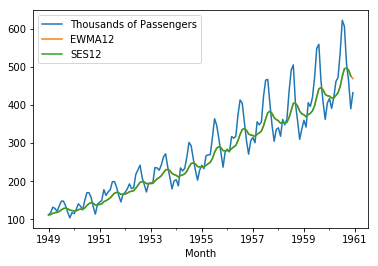

In [33]:
df.plot();

In [35]:
# DES using an Additive Model as the above trend seems straight-lined (assumption)

df['DES_add_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)

1. trend param : defines growth or decay of trend

  > for a TS showing straight-line sloped trend , use ADDITIVE trend <br>
  > for an exponential / curved trend : use MULTIPLICATIVE trend

In [36]:
df.head()

,Thousands of Passengers,EWMA12,SES12,DES_add_12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.336774
1949-02-01,118,112.923077,112.923077,120.336774
1949-03-01,132,115.857988,115.857988,134.336774
1949-04-01,129,117.879836,117.879836,131.336774
1949-05-01,121,118.359861,118.359861,123.336774


In [37]:
df.columns

Index(['Thousands of Passengers', 'EWMA12', 'SES12', 'DES_add_12'], dtype='object')

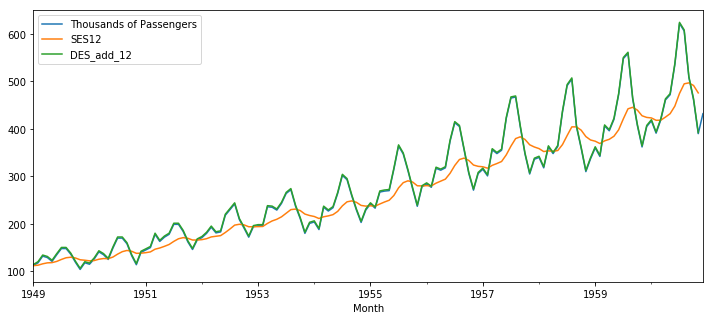

In [41]:
ax = df[ ['Thousands of Passengers', 'SES12', 'DES_add_12']].plot(figsize=(12,5));

ax.autoscale(axis='x', tight=True)

In [42]:
#notice that DES_add_12 falls too close to 'Thousands of Passengers'

#we'll zoom in a particular time range to see it, using iloc[]

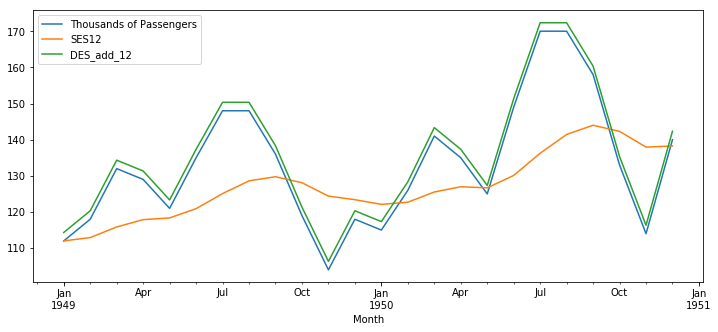

In [44]:
df[ ['Thousands of Passengers', 'SES12', 'DES_add_12']].iloc[ : 24].plot(figsize=(12,5));

#first 2 years using iloc[]

using DES_add we're able yto describe our series pretty well, just by adding a trend component.

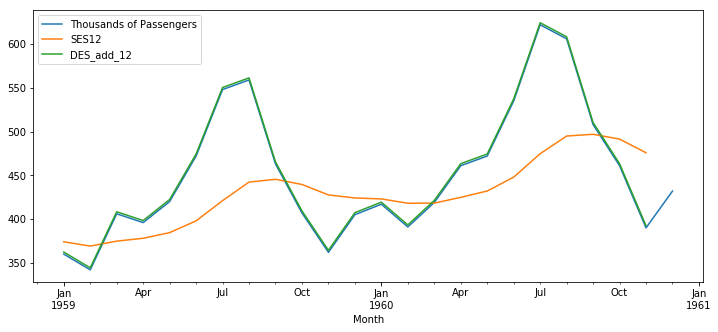

In [46]:
# seeing last 2 years' data fit

df[ ['Thousands of Passengers', 'SES12', 'DES_add_12']].iloc[-24 : ].plot(figsize=(12,5));

SO the recent data FITS EVEN BETTER !

so just adding one term improved the model fit and data explanation so much .

wait till you see what TES does !

if you cant decide if you should use Additive or Multiplicative trend, then try both in two columns, plot them both wrt the original data and see what performs better. <br>

eg : DES_add_12 v/s DES_mul_12

> choose the one that fits better in both : old & recent data

above model fits better in MULTIPLICATIVE TREND but we used additive 

In [60]:
df['DES_mul_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)

In [61]:
df.columns

Index(['Thousands of Passengers', 'EWMA12', 'SES12', 'DES_add_12',
       'TES_mul_12', 'DES_mul_12'],
      dtype='object')

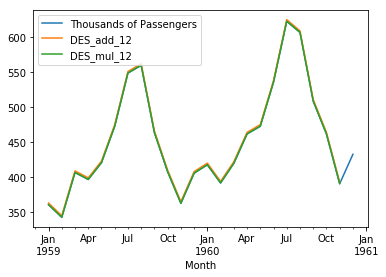

In [64]:
# plotting against recent 24 month values

df[['Thousands of Passengers', 'DES_add_12', 'DES_mul_12']].iloc[ -24 :].plot();

#both perform equally well

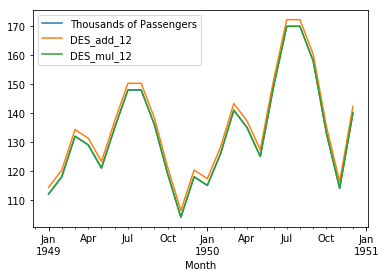

In [67]:
# plotting against oldest 24 month values

df[['Thousands of Passengers', 'DES_add_12', 'DES_mul_12']].iloc[ : 24].plot();

#mul one fits better

 so for TREND Component , 'mul' is the clear winner



# TRIPLE ES - HWSM

In [68]:
# nothing to import, same func as DES is utilised

#coz MUL performed better above so we'll use it here instead of additive

model2 = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul', seasonal='mul', seasonal_periods = 12)

here, you've to decide the SEASONALITY COMPONENT TOO. 

> if seasonality is changing LINEARLY or MULTIPLICATIVELY

<i> the SEASONAL_PERIODS is equivalent to L (divisions per cycle) from math

#### now here we've 4 combinations here 

1. t = 'mul' , s = 'mul'
2. t = 'mul' , s = 'add'
3. t = 'add' , s = 'mul'
4. t = 'add' , s = 'add'

test them all to test the best fitting model line wrt the main data. ['Thousands of Pas']

<b> use a METRIC to decide which is better fit </b> (discussed later)

In [69]:
fittedmodel_2 = model.fit()  #trained TES model

In [70]:
df['TES_mul_12'] = fittedmodel_2.fittedvalues

In [71]:
# in TES, dont worry abt the shift

In [72]:
df.columns

Index(['Thousands of Passengers', 'EWMA12', 'SES12', 'DES_add_12',
       'TES_mul_12', 'DES_mul_12'],
      dtype='object')

In model2, we're assuming tha the general trend is increasing exponentially, as well as the seasonality in that growth is also exponential 

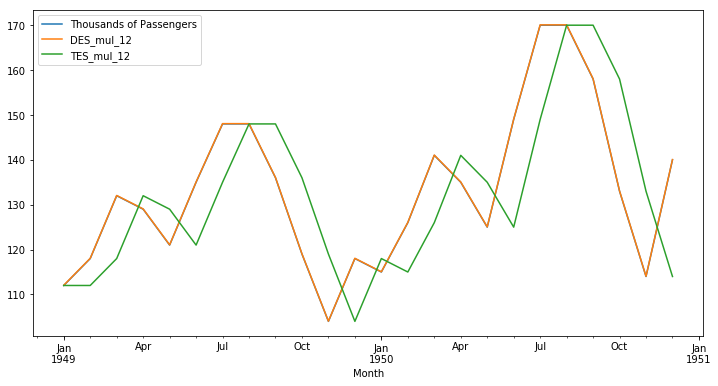

In [75]:
# beginning data zoomed in

df[['Thousands of Passengers', 'DES_mul_12',
       'TES_mul_12']].iloc[:24].plot(figsize=(12,6));

here it seems that TES_mul is doing WORSE job than DES_mul . 

ie DES_mul aligns with the main data

WHY???????

<b> coz we expected that higher model complexity will mean the result fits better to the df ? </b>

<u> In forecasting, our aim is to predict fluctuations in seasonal component so that we can predict the data better </u>

so remember 

1. for beginning data, simpler models will fit better

2. for recent most data, complex models will fir better

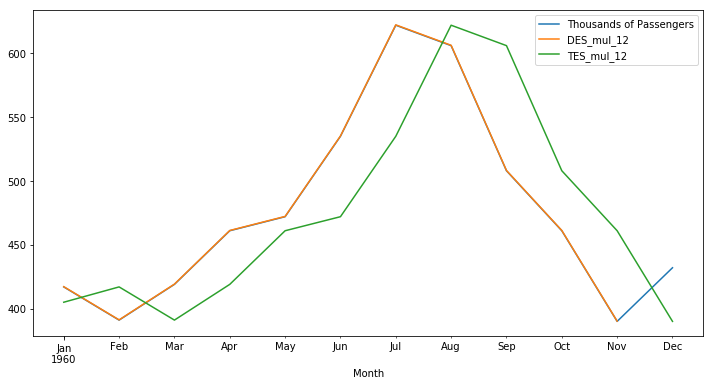

In [77]:
# eg : see TES sits better than DES for last 24 values

df[['Thousands of Passengers', 'DES_mul_12',
       'TES_mul_12']].iloc[-12:].plot(figsize=(12,6));

# i dont understand the last plot and how TES fits better? 

remember, freq definition for index is first and most crucial step here to use statsmodel.

now after creating > fitting & calling the fittedvalues, we'll use forecasting to predict for the timestamps that are not in our time series data. 